<a href="https://colab.research.google.com/github/abbbe/autoenc/blob/main/robot-arm-vae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies << only once, restart the runtime after this

In [1]:
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay
!pip -q install pygame
 
!git clone https://github.com/ekorudiawan/gym-robot-arm.git
!cd gym-robot-arm && pip install -e .

     |████████████████████████████████| 11.8MB 19.8MB/s 
Cloning into 'gym-robot-arm'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 37 (delta 10), reused 34 (delta 7), pack-reused 0
Unpacking objects: 100% (37/37), done.
Obtaining file:///content/gym-robot-arm
  Running setup.py develop for gym-robot-arm


## Load required modules << after each runtime restart

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym 
import pygame
import numpy as np
import skimage.transform

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model, layers
%load_ext tensorboard

pygame 2.0.1 (SDL 2.0.14, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Gym << if you plan to interact with the robot

In [ ]:
# instantiate robot arm
env = gym.make('gym_robot_arm:robot-arm-v1')
env.draw_target = lambda: None # sabotage target (red circle) drawing

D = 64 # screen will be scaled to DxD

def get_pygame_display_img_array():
    img_surface = pygame.display.get_surface()
    img_array = pygame.surfarray.array3d(img_surface)
    return img_array

def get_Y():
    """
    Returns a screenshot of the current game screen as 2D numpy array.
    Converted to grayscale, resized to DxD.
    """
    img_array = get_pygame_display_img_array()
    # convert to grayscale
    img_array = np.average(img_array, axis=2)

    # resize (preserves channels)
    img_array = skimage.transform.resize(img_array, (D, D))

    #from PIL import Image
    #import matplotlib.pyplot as plt
    #img = Image.fromarray(img_array)
    #img.show()

    return img_array / 255.

def plot_Ys(ys):
    """
    Plot given DxD greyscale images
    """
    _fig, axs = plt.subplots(1, ys.shape[0])
    for i in range(ys.shape[0]):
        axs[i].imshow(ys[i])

# TRAIN AND SAVE << or skip all the way down to LOAD AND USE
## Generate train, test, and validation data

In [ ]:
def gen_data(N):
    """
    Generate testdata: actions and robot views
    """
    env.reset()

    print("Generating %d snapshots of the robot" % N)
    for i in range(N):
        action = env.action_space.sample()
        obs, _reward, _done, _info = env.step(action)
        env.render()

        y = get_Y()

        if i == 0:
            A = np.zeros([N] + list(action.shape))
            Y = np.zeros([N] + list(y.shape))

        A[i] = action.flatten()
        Y[i] = y

    env.close()

    Y = np.expand_dims(Y, axis=-1)
    return A, Y

In [ ]:
# 1000 train, 100 test, 100 validate
train_A, train_Y = gen_data(1000)
test_A, test_Y = gen_data(100)
val_A, val_Y = gen_data(100)

In [ ]:
print("train_A.shape=%s, train_Y.shape=%s" % (str(train_A.shape), str(train_Y.shape)))
plot_Ys(train_Y[:3,...])

## Build the model

In [ ]:
#https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np

In [ ]:
def build_conv_autoencoder(width, height, depth, latentDim, filters=(256,16)):
    
    def build_encoder(inp):
        x = inp
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        # flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inp, latent, name="encoder")
        return encoder, volumeSize
    
    def build_decoder(latentInputs, volumeSize):
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        # loop over our number of filters again, but this time in reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        # apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        decoder = Model(latentInputs, outputs, name="decoder")
        return decoder

    inputShape = (height, width, depth)
    chanDim = -1
   
    inputs = Input(shape=inputShape)
    encoder_model, volumeSize = build_encoder(inputs)

    latentInputs = Input(shape=(latentDim,))
    decoder_model = build_decoder(latentInputs, volumeSize)

    autoencoder = Model(inputs, decoder_model(encoder_model(inputs)), name="autoencoder")
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return autoencoder, encoder_model, decoder_model

In [ ]:
#from numba import cuda
#device = cuda.get_current_device()
#device.reset()

In [ ]:
autoencoder, encoder, decoder = build_conv_autoencoder(train_Y.shape[1], train_Y.shape[2], 1, 2)
print(encoder.summary())
print(decoder.summary())

## Fit the model

In [ ]:
#autoencoder.fit(train_Y, train_Y, batch_size=64, epochs=250, validation_data=(test_Y, test_Y), verbose=1)
def train_model():
    import os, datetime
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir) #, histogram_freq=1)
    autoencoder.fit(train_Y, train_Y, batch_size=64, epochs=50, validation_data=(test_Y, test_Y), verbose=0,
                    callbacks=[tensorboard_callback])

In [ ]:
for _ in range(1):
    train_model()

## Evaluate

In [ ]:
L = encoder.predict(train_Y)
YY = decoder.predict(L)

### plot latent vars histogram (on training data)

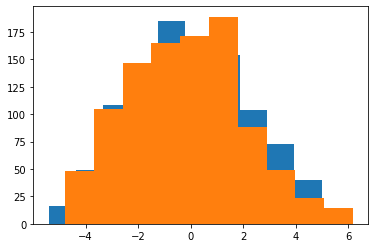

In [ ]:
for i in range(L.shape[1]):
    plt.hist(L[:, i])

### show 3 pairs of real / regenerated images (from training data)

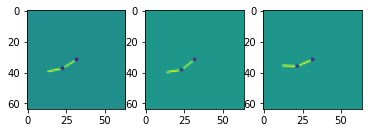

In [ ]:
# draw first 3 real robot views from the training set, then generated ones
plot_Ys(train_Y[[0,1,2],...])

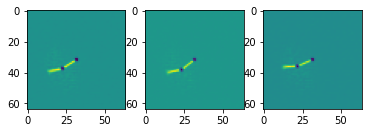

In [ ]:
plot_Ys(YY[[0,1,2],...])

## Validation

In [ ]:
val_L = encoder.predict(val_Y)
val_YY = decoder.predict(val_L)

In [ ]:
plot_Ys(val_Y[[0,1,2],...])

In [ ]:
plot_Ys(val_YY[[0,1,2],...])

In [ ]:
# plot the latent vars (vertical axis) vs joint[0] (horizontal)
_fig, axs = plt.subplots(val_L.shape[1])
for i in range(val_L.shape[1]):
    axs[i].plot(val_A[:,0], val_L[:, i], '.')

In [ ]:
# plot the latent vars (vertical axis) vs joint[1] (horizontal)
_fig, axs = plt.subplots(val_L.shape[1])
for i in range(val_L.shape[1]):
    axs[i].plot(val_A[:,1], val_L[:, i], '.')

## Save the data and the models

In [ ]:
import pickle

print(train_Y.shape)
with open('robot-arm-vae2-dataset.pickle', 'wb') as handle:
    pickle.dump([train_A, train_Y, test_A, test_Y, val_A, val_Y, val_L], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
autoencoder.save('robot-arm-vae2-autoencoder.h5')
encoder.save('robot-arm-vae2-encoder.h5')
decoder.save('robot-arm-vae2-decoder.h5')

# LOAD AND USE

## Grab autoenc/ repo and chdir there << useful when opening notebook in **Colab**

In [2]:
!git clone https://github.com/abbbe/autoenc.git
%cd autoenc

Cloning into 'autoenc'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 6), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (13/13), done.
/content/autoenc


## Load data

In [3]:
import pickle
# Load data
with open('robot-arm-vae2-dataset.pickle', 'rb') as handle:
    [train_A, train_Y, test_A, test_Y, val_A, val_Y, val_L] = pickle.load(handle)
print(train_Y.shape)

(1000, 64, 64, 1)


## Load autoencoder models and weights from files

In [4]:
from tensorflow import keras

autoencoder = keras.models.load_model("robot-arm-vae2-autoencoder.h5")
encoder = keras.models.load_model("robot-arm-vae2-encoder.h5")
decoder = keras.models.load_model("robot-arm-vae2-decoder.h5")

# Change latent variables and render live decoder output

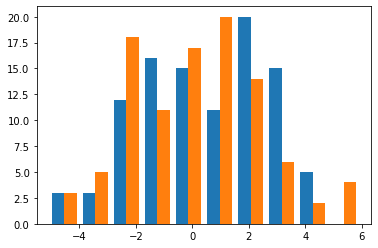

In [5]:
_=plt.hist(val_L)

In [5]:
import ipywidgets as widgets
from IPython.display import display

slider0 = widgets.FloatSlider(value=0.0, min=-5, max=5, step=0.01)
slider1 = widgets.FloatSlider(value=0.0, min=-5, max=5, step=0.01)
#button = widgets.Button(description="Redraw")
output = widgets.Output()
 
def redraw(_):
    with output:
        output.clear_output(wait=True)
        #print("# %f %f" % (slider0.value, slider1.value))
        
        #L = np.expand_dims([slider0.value, slider1.value], axis=0)
        L = np.array([
             [slider0.value, slider1.value],
             [slider0.value, slider1.value],
        ])

        Ys = decoder.predict(L)

        plt.clf()
        plt.imshow(Ys[0,:,:,0])
        plt.show()

slider0.observe(redraw, names='value')
slider1.observe(redraw, names='value')

#button.on_click(redraw)
#display(button, output)
display(output, slider0, slider1)
redraw(None)

Output()

FloatSlider(value=0.0, max=5.0, min=-5.0, step=0.01)

FloatSlider(value=0.0, max=5.0, min=-5.0, step=0.01)